#Connecting colab to Google Drive

In [ ]:
#Connect your Google Drive  
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Check list files of target file directory 

In [ ]:
import os

# Walk through Corona_Normal directory and list number of files
for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/Corona_normal"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 3 directories and 0 images in '/content/drive/MyDrive/Corona_normal'.
There are 2 directories and 0 images in '/content/drive/MyDrive/Corona_normal/Test'.
There are 0 directories and 978 images in '/content/drive/MyDrive/Corona_normal/Test/Normal'.
There are 0 directories and 228 images in '/content/drive/MyDrive/Corona_normal/Test/Covid'.
There are 2 directories and 0 images in '/content/drive/MyDrive/Corona_normal/Train'.
There are 0 directories and 1826 images in '/content/drive/MyDrive/Corona_normal/Train/Covid'.
There are 0 directories and 7821 images in '/content/drive/MyDrive/Corona_normal/Train/Normal'.
There are 2 directories and 0 images in '/content/drive/MyDrive/Corona_normal/Validation'.
There are 0 directories and 978 images in '/content/drive/MyDrive/Corona_normal/Validation/Normal'.
There are 0 directories and 228 images in '/content/drive/MyDrive/Corona_normal/Validation/Covid'.


#Check and view the Dataset

##Get the class names based on the the name of subdirectories

In [ ]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("/content/drive/MyDrive/Corona_normal/Train") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['Covid' 'Normal']


##View image method

In [ ]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

##Visualize data and comparing Covid and Normal CT scan

Image shape: (512, 512)
Image shape: (512, 512)


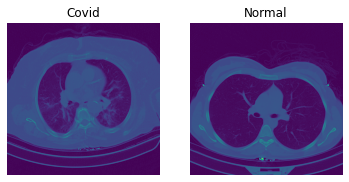

In [ ]:
# Visualize data (requires function 'view_random_image' above)
plt.figure()
plt.subplot(1, 2, 1)
steak_img = view_random_image("/content/drive/MyDrive/Corona_normal/Train/", "Covid")
plt.subplot(1, 2, 2)
pizza_img = view_random_image("/content/drive/MyDrive/Corona_normal/Train/", "Normal")

#Preprocessing dataset

##Set the data generator for applying Data Augmentation methods



In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

# Set the seed
tf.random.set_seed(42)
#Here we set the data generators for applying data augmentation methods
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, 
    rescale=1.0/255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.05,
    rotation_range=360,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05)
valid_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1.0/255)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rescale=1.0/255)

# Setup the train and test directories
train_dir = "/content/drive/MyDrive/Corona_normal/Train/"
valid_dir = "/content/drive/MyDrive/Corona_normal/Validation"
test_dir = "/content/drive/MyDrive/Corona_normal/Test/"

shape=(512,512,1) #shape of the dataset images (in TIFF format)

##Import data from directories and turn it into batches

In [ ]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    batch_size=5, # number of images to process at a time 
    target_size=shape[:2], # convert all images to be 224 x 224
    class_mode="categorical", # type of problem we're working on
    seed=42,
    color_mode="grayscale",shuffle=True)
valid_data = test_datagen.flow_from_directory(
    valid_dir,
    batch_size=5, # number of images to process at a time 
    target_size=shape[:2], # convert all images to be 224 x 224
    class_mode="categorical", # type of problem we're working on
    seed=42,
    color_mode="grayscale",shuffle=True)
test_data = test_datagen.flow_from_directory(
    test_dir,
    batch_size=5, # number of images to process at a time 
    target_size=shape[:2], # convert all images to be 224 x 224
    class_mode="categorical", # type of problem we're working on
    seed=42,
    color_mode="grayscale",shuffle=True)

Found 9647 images belonging to 2 classes.
Found 1206 images belonging to 2 classes.
Found 1206 images belonging to 2 classes.


##Check class indices

In [ ]:
# show class indices
print('****************')
for cls, idx in train_data.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))
print('****************')

****************
Class #0 = Covid
Class #1 = Normal
****************


#Create a CNN Inception-ResnetV2 model 

##Import Libraries

In [ ]:
# Importing the required libraries 

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Concatenate, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers, activations
from tensorflow.experimental.numpy import ndim
import os
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
#import itertools
#import shutil
%matplotlib inline

##Additional code from stack over flow "How to solve 'No Algorithm Worked' Keras Error?" 

In [ ]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

##Convolutional Block

In [ ]:
def conv2d(x,numfilt,filtsz,strides=1,pad='same',act=True,name=None):
  x = Conv2D(numfilt,filtsz,strides,padding=pad,data_format='channels_last',use_bias=False,name=name+'conv2d')(x)
  x = BatchNormalization(axis=3,scale=False,name=name+'conv2d'+'bn')(x)
  if act:
    x = Activation('relu',name=name+'conv2d'+'act')(x)
  return x

##Inception ResNet A block

In [ ]:
def incresA(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,32,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,32,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,32,3,1,pad,True,name=name+'b1_2')
    branch2 = conv2d(x,32,1,1,pad,True,name=name+'b2_1')
    branch2 = conv2d(branch2,48,3,1,pad,True,name=name+'b2_2')
    branch2 = conv2d(branch2,64,3,1,pad,True,name=name+'b2_3')
    branches = [branch0,branch1,branch2]
    mixed = Concatenate(axis=3, name=name + '_concat')(branches)
    filt_exp_1x1 = conv2d(mixed,384,1,1,pad,False,name=name+'filt_exp_1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])
    return final_lay

##Inception ResNet B block

In [ ]:
def incresB(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,192,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,128,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,160,[1,7],1,pad,True,name=name+'b1_2')
    branch1 = conv2d(branch1,192,[7,1],1,pad,True,name=name+'b1_3')
    branches = [branch0,branch1]
    mixed = Concatenate(axis=3, name=name + '_mixed')(branches)
    filt_exp_1x1 = conv2d(mixed,1152,1,1,pad,False,name=name+'filt_exp_1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_scaling')([x, filt_exp_1x1])
    return final_lay

##Inception ResNet C block 

In [ ]:
def incresC(x,scale,name=None):
    pad = 'same'
    branch0 = conv2d(x,192,1,1,pad,True,name=name+'b0')
    branch1 = conv2d(x,192,1,1,pad,True,name=name+'b1_1')
    branch1 = conv2d(branch1,224,[1,3],1,pad,True,name=name+'b1_2')
    branch1 = conv2d(branch1,256,[3,1],1,pad,True,name=name+'b1_3')
    branches = [branch0,branch1]
    mixed = Concatenate(axis=3, name=name + '_mixed')(branches)
    filt_exp_1x1 = conv2d(mixed,2048,1,1,pad,False,name=name+'fin1x1')
    final_lay = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
                      output_shape=backend.int_shape(x)[1:],
                      arguments={'scale': scale},
                      name=name+'act_saling')([x, filt_exp_1x1])
    return final_lay

##Stem block

In [ ]:
img_input = Input(shape=(512,512,1))

x = conv2d(img_input,32,3,2,'valid',True,name='conv1')
x = conv2d(x,32,3,1,'valid',True,name='conv2')
x = conv2d(x,64,3,1,'valid',True,name='conv3')

x_11 = MaxPooling2D(3,strides=2,padding='valid',name='stem_br_11'+'_maxpool_1')(x)
x_12 = conv2d(x,96,3,2,'valid',True,name='stem_br_12')

x = Concatenate(axis=3, name = 'stem_concat_1')([x_11,x_12])

x_21 = conv2d(x,64,1,1,'same',True,name='stem_br_211')
x_21 = conv2d(x_21,64,[1,7],1,'same',True,name='stem_br_212')
x_21 = conv2d(x_21,64,[7,1],1,'same',True,name='stem_br_213')
x_21 = conv2d(x_21,96,3,1,'valid',True,name='stem_br_214')

x_22 = conv2d(x,64,1,1,'same',True,name='stem_br_221')
x_22 = conv2d(x_22,96,3,1,'valid',True,name='stem_br_222')

x = Concatenate(axis=3, name = 'stem_concat_2')([x_21,x_22])

x_31 = conv2d(x,192,3,1,'valid',True,name='stem_br_31')
x_32 = MaxPooling2D(3,strides=1,padding='valid',name='stem_br_32'+'_maxpool_2')(x)
x = Concatenate(axis=3, name = 'stem_concat_3')([x_31,x_32])

##Inception-ResNet Network

In [ ]:
#Inception-ResNet-A modules
x = incresA(x,0.15,name='incresA_1')
x = incresA(x,0.15,name='incresA_2')
x = incresA(x,0.15,name='incresA_3')
x = incresA(x,0.15,name='incresA_4')

#35 × 35 to 17 × 17 reduction module.
x_red_11 = MaxPooling2D(3,strides=2,padding='valid',name='red_maxpool_1')(x)

x_red_12 = conv2d(x,384,3,2,'valid',True,name='x_red1_c1')

x_red_13 = conv2d(x,256,1,1,'same',True,name='x_red1_c2_1')
x_red_13 = conv2d(x_red_13,256,3,1,'same',True,name='x_red1_c2_2')
x_red_13 = conv2d(x_red_13,384,3,2,'valid',True,name='x_red1_c2_3')

x = Concatenate(axis=3, name='red_concat_1')([x_red_11,x_red_12,x_red_13])

#Inception-ResNet-B modules
x = incresB(x,0.1,name='incresB_1')
x = incresB(x,0.1,name='incresB_2')
x = incresB(x,0.1,name='incresB_3')
x = incresB(x,0.1,name='incresB_4')
x = incresB(x,0.1,name='incresB_5')
x = incresB(x,0.1,name='incresB_6')
x = incresB(x,0.1,name='incresB_7')

#17 × 17 to 8 × 8 reduction module.
x_red_21 = MaxPooling2D(3,strides=2,padding='valid',name='red_maxpool_2')(x)

x_red_22 = conv2d(x,256,1,1,'same',True,name='x_red2_c11')
x_red_22 = conv2d(x_red_22,384,3,2,'valid',True,name='x_red2_c12')

x_red_23 = conv2d(x,256,1,1,'same',True,name='x_red2_c21')
x_red_23 = conv2d(x_red_23,256,3,2,'valid',True,name='x_red2_c22')

x_red_24 = conv2d(x,256,1,1,'same',True,name='x_red2_c31')
x_red_24 = conv2d(x_red_24,256,3,1,'same',True,name='x_red2_c32')
x_red_24 = conv2d(x_red_24,256,3,2,'valid',True,name='x_red2_c33')

x = Concatenate(axis=3, name='red_concat_2')([x_red_21,x_red_22,x_red_23,x_red_24])

#Inception-ResNet-C modules
x = incresC(x,0.2,name='incresC_1')
x = incresC(x,0.2,name='incresC_2')
x = incresC(x,0.2,name='incresC_3')

#TOP
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.6)(x)
x = Dense(units=2, activation='softmax')(x)

##Make the model and get the summary of the model




In [ ]:
model = Model(img_input,x,name='inception_resnet_v2')
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 1) 0                                            
__________________________________________________________________________________________________
conv1conv2d (Conv2D)            (None, 255, 255, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
conv1conv2dbn (BatchNormalizati (None, 255, 255, 32) 96          conv1conv2d[0][0]                
__________________________________________________________________________________________________
conv1conv2dact (Activation)     (None, 255, 255, 32) 0           conv1conv2dbn[0][0]              
________________________________________________________________________________

#Compile the model

In [ ]:
model.compile(Adam(learning_rate=0.01), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

##Check lengths of training and test data

In [ ]:
# Check lengths of training and test data 
len(train_data), len(valid_data)

(1930, 242)

##Model Checkpoint

In [ ]:
filepath = 'model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', 
                        verbose=1, save_best_only=True, mode='max')

##Early Stopping

In [ ]:
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=4, restore_best_weights=True)
callbacks_list = [checkpoint, early]

#Train the model

In [ ]:
history = model.fit_generator(train_data,
                              steps_per_epoch=len(train_data),          
                              validation_data=valid_data,
                              validation_steps=len(valid_data), 
                              epochs = 2)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2
1930/1930 [==============================] - 4404s 2s/step - loss: 1.1313 - accuracy: 0.7587 - val_loss: 0.4583 - val_accuracy: 0.8590
Epoch 2/2
1930/1930 [==============================] - 4199s 2s/step - loss: 0.8333 - accuracy: 0.8146 - val_loss: 0.4695 - val_accuracy: 0.8814


Hasil terakhir
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Epoch 1/2
1930/1930 [==============================] - 4532s 2s/step - loss: 1.0374 - accuracy: 0.7653 - val_loss: 0.5281 - val_accuracy: 0.8209
Epoch 2/2
 634/1930 [========>.....................] - ETA: 46:32 - loss: 0.5310 - accuracy: 0.8306

Hasil terakhir training
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
Epoch 1/3
1930/1930 [==============================] - 4305s 2s/step - loss: 1.0847 - accuracy: 0.7740 - val_loss: 2.5439 - val_accuracy: 0.8400
Epoch 2/3
1930/1930 [==============================] - 4043s 2s/step - loss: 0.8960 - accuracy: 0.8125 - val_loss: 0.4963 - val_accuracy: 0.8706
Epoch 3/3
1930/1930 [==============================] - 4038s 2s/step - loss: 0.6535 - accuracy: 0.8432 - val_loss: 1.9013 - val_accuracy: 0.8159

## Plot the training curves

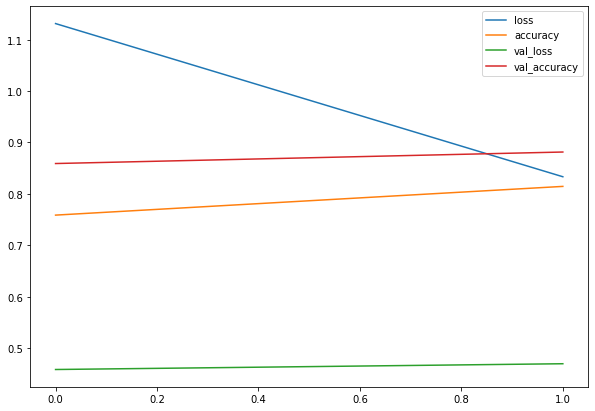

In [ ]:
# Plot the training curves
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(10, 7));

#Evaluate the model

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

## Check out the loss curves of model

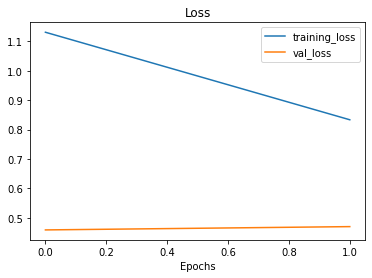

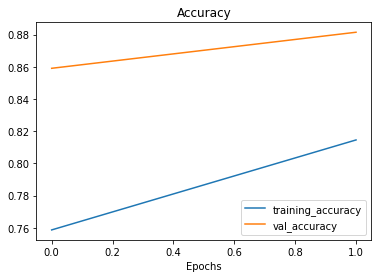

In [ ]:
# Check out the loss curves of model
plot_loss_curves(history)

## Evaluate on the test data

In [ ]:
# Evaluate on the test data
model.evaluate(test_data)

242/242 [==============================] - 270s 1s/step - loss: 0.4511 - accuracy: 0.8590


[0.4511061906814575, 0.8590381145477295]

#Saving and loading Model

## Save our model

In [ ]:
# Save a model
model.save("saved_trained_model")

INFO:tensorflow:Assets written to: saved_trained_model/assets


## Load in our model and evaluate it

In [ ]:
# Load in a model and evaluate it
loaded_model = tf.keras.models.load_model("saved_trained_model")
loaded_model.evaluate(test_data)

242/242 [==============================] - 155s 634ms/step - loss: 0.4511 - accuracy: 0.8590


[0.45110639929771423, 0.8590381145477295]

## Compare our unsaved model's results (same as above)

In [ ]:
# Compare our unsaved model's results (same as above)
model.evaluate(test_data)

242/242 [==============================] - 152s 629ms/step - loss: 0.4511 - accuracy: 0.8590


[0.45110633969306946, 0.8590381145477295]